In [1]:
import numpy as np
import torch.nn as nn
import torch, torchvision

import matplotlib.pyplot as plt

from Analog2SpikeDataset import SpikeDataset
from torch.utils.data import DataLoader

In [2]:
torch.manual_seed(0)

In [3]:
if torch.cuda.is_available():               # check GPU availability
    device = torch.device('cuda')
    print('device: ', torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')

device:  NVIDIA RTX A4000


## Simulation Parameters

In [4]:
batch_size = 256
nb_steps = 100
lr = 2e-4
epochs = 30
root = 'datasets'

## Training Data

In [5]:
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)

train_spks = SpikeDataset(train_dataset, num_steps=nb_steps)
test_spks = SpikeDataset(test_dataset, num_steps=nb_steps)

train_loader = DataLoader(train_spks, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_spks, batch_size=batch_size, shuffle=True, drop_last=True)

In [6]:
sample = train_spks[1]
x_ = sample[0]
y_ = sample[1]

x_ = np.array(x_.tolist())
y_ = np.array(y_.tolist())

#train_spks.plot_sample(idx=1, save=True)

/home/p302242/github/csnn_if_neur/csnn/Analog2SpikesTransforms.py:95: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1708025845868/work/torch/csrc/utils/tensor_new.cpp:275.)
  indices = torch.tensor(coo_, dtype=torch.int64)                             # [[total time steps], [input gridcell x axis], [input gridcell y axis]]


## Neuron Model

In [7]:
from SurrogateGradient import SpkSurrogateGradFunction

class IFlayer(nn.Module):
    def __init__(self, threshold=1.0, output=False):
        super().__init__()

        self.threshold = threshold
        self.output = output

        self.spike_fn = SpkSurrogateGradFunction.apply
        
        self.forwarded = False

    def reset_mem(self):
        self.forwarded = False
    
    def forward(self, x, k):

        if not hasattr(self, 'mem') or not self.forwarded:
            self.mem = torch.zeros_like(x, requires_grad=True)
            self.forwarded = True

        spk = self.spike_fn(self.mem, self.threshold, k)
        rst = spk.detach()
        
        if self.output:
            self.mem = self.mem + x
        else:
            self.mem = self.mem + x - rst*self.threshold

        return spk, self.mem

## Spiking CONV Network

In [8]:
class SCNN(nn.Module):
    def __init__(self, device, input_size=(28,28), nb_fc_units=100, nb_outputs=10):
        super().__init__()

        self.k = np.float64(100.0)

        # --- 1st conv layer
        self.k1 = 3
        self.nb_filters1 = 4
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=self.nb_filters1, kernel_size=self.k1, stride=1, padding=0, bias=False)
        self.convif1 = IFlayer()
        self.sumpool1 = nn.AvgPool2d(kernel_size=2, stride=1, divisor_override=1)

        SCNN.conv_weight_init(self.conv1.weight, self.k1, self.nb_filters1)

        outs1 = SCNN.conv_output_size(input_size, conv_st=1, conv_pd=0, conv_ks=self.k1, poo_ks=2, poo_st=1)

        # --- 2nd conv layer
        self.k2 = 3
        self.nb_filters2 = 8
        self.conv2 = nn.Conv2d(in_channels=self.nb_filters1, out_channels=self.nb_filters2, kernel_size=self.k2, stride=1, padding=0, bias=False)
        self.convif2 = IFlayer()
        self.sumpool2 = nn.AvgPool2d(kernel_size=2, stride=1, divisor_override=1)

        SCNN.conv_weight_init(self.conv2.weight, self.k2, self.nb_filters2)

        outs2 = SCNN.conv_output_size(outs1, conv_st=1, conv_pd=0, conv_ks=self.k2, poo_ks=2, poo_st=1)

        # --- FC layers
        nb_fc = self.nb_filters2*outs2[0]*outs2[1]

        self.fc1if = IFlayer()
        self.fc2if = IFlayer(output=True)

        # --- Weight matrix between last Conv layer and firt FC layer
        self.w_conv_fc = torch.empty((nb_fc, nb_fc_units), device=device, dtype=torch.float, requires_grad=True)
        torch.nn.init.normal_(self.w_conv_fc, mean=0.0, std=1/np.sqrt(nb_fc))

        # --- Weight matrix between FC layer and output layer
        self.w_fc_out = torch.empty((nb_fc_units, nb_outputs), device=device, dtype=torch.float, requires_grad=True)
        torch.nn.init.normal_(self.w_fc_out, mean=0.0, std=1/np.sqrt(nb_fc_units))

        print(outs1)
        print(outs2)
        print(nb_fc)
        print(nb_fc_units)
        print(nb_outputs)

    def forward(self, x):
        batch_size = x.size(0)

        # --- 1st conv layer
        out = self.conv1(x)
        out, mem1 = self.convif1(out, self.k)
        out = self.sumpool1(out)

        # --- 2nd conv layer
        out = self.conv2(out)
        out, mem2 = self.convif2(out, self.k)
        out = self.sumpool2(out)

        # --- FC layer 1
        _flat = out.view(batch_size, -1)
        _inp_fc = torch.einsum('ij,jk->ik', (_flat, self.w_conv_fc))
        out, mem3 = self.fc1if(_inp_fc, self.k)

        # --- FC layer 2
        _inp_o = torch.einsum('ij,jk->ik', (out, self.w_fc_out))
        out, mem4 = self.fc2if(_inp_o, self.k)

        return out, mem4
    
    def reset_states(self):
        self.convif1.reset_mem()
        self.convif2.reset_mem()
        self.fc1if.reset_mem()
        self.fc2if.reset_mem()
    
    @staticmethod
    def model_forward(model, data, nb_steps):
        spk_out_all = []
        mem_out_all = []
        model.reset_states()

        for step in range(nb_steps):
            spk_out, mem_out = model.forward(data[:, step:step+1, :, :])

            spk_out_all.append(spk_out)
            mem_out_all.append(mem_out)

        return torch.stack(spk_out_all, dim=1), torch.stack(mem_out_all, dim=1)
    
    @staticmethod
    def conv_weight_init(w_matrix, conv_ks, nb_filters):
        torch.nn.init.normal_(w_matrix, mean=0.0, std=1/np.sqrt((conv_ks**2)*nb_filters))

    @staticmethod
    def conv_output_size(input_size, conv_st, conv_pd, conv_ks, poo_ks, poo_st):
        conv_output_size = [(size + 2 * conv_pd - conv_ks) // conv_st + 1 for size in input_size]   # xonvolution with padding=1 and stride=1
        pool_output_size = [(size - poo_ks) // poo_st + 1 for size in conv_output_size]             # max pooling with size=2 and stride=1
        return pool_output_size

In [9]:
model = SCNN(device=device).to(device)

[25, 25]
[22, 22]
3872
100
10


## Optimizer & Loss

In [10]:
params = [model.conv1.weight, model.conv2.weight, model.w_conv_fc, model.w_fc_out]
optimizer = torch.optim.Adam(params, lr=lr)

In [11]:
log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

## Training Loop

In [12]:
loss_hist = []
model.train()

for e in range(epochs):
    local_loss = []
    
    for data, targets in iter(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # forward pass
        out_spks, out_mems = SCNN.model_forward(model, data, nb_steps)
        m, _ = torch.max(out_mems, 1)
        log_p_y = log_softmax_fn(m)

        # initialize the loss & sum over time
        loss_val = loss_fn(log_p_y, targets.long())

        # gradient calculation + weight update
        optimizer.zero_grad()
        loss_val.backward()
        optimizer.step()

        local_loss.append(loss_val.item())
    
    mean_loss = np.mean(local_loss)
    print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
    loss_hist.append(mean_loss)

Epoch 1: loss=1.83985
Epoch 2: loss=1.18625
Epoch 3: loss=1.11844
Epoch 4: loss=0.75914
Epoch 5: loss=0.66350
Epoch 6: loss=0.63737
Epoch 7: loss=0.62730
Epoch 8: loss=0.64245
Epoch 9: loss=0.61710
Epoch 10: loss=0.59623
Epoch 11: loss=0.57625
Epoch 12: loss=0.56408
Epoch 13: loss=0.56315
Epoch 14: loss=0.58960
Epoch 15: loss=0.59921
Epoch 16: loss=0.59256
Epoch 17: loss=0.58392
Epoch 18: loss=0.57557
Epoch 19: loss=0.56424
Epoch 20: loss=0.55223
Epoch 21: loss=0.55365
Epoch 22: loss=0.55043
Epoch 23: loss=0.54417
Epoch 24: loss=0.53734
Epoch 25: loss=0.54271
Epoch 26: loss=0.54457
Epoch 27: loss=0.54328
Epoch 28: loss=0.53334
Epoch 29: loss=0.52719
Epoch 30: loss=0.55228


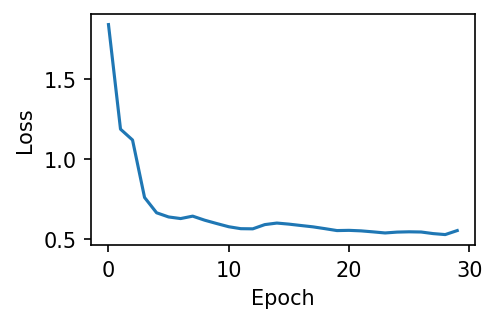

In [13]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

## Accuracy

In [14]:
accs = []
with torch.no_grad():
    total = 0
    correct = 0
    model.eval()

    test_loader = iter(test_loader)

    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        out_spks, out_mems = SCNN.model_forward(model, data, nb_steps)

        m,_= torch.max(out_mems,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((targets==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)

mean_acc = np.mean(accs)
print(f'test accuracy: {mean_acc}')

test accuracy: 0.7912660256410257


In [15]:
accs = []
with torch.no_grad():
    total = 0
    correct = 0
    model.eval()

    train_loader = iter(train_loader)

    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)

        out_spks, out_mems = SCNN.model_forward(model, data, nb_steps)

        m,_= torch.max(out_mems,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((targets==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)

mean_acc = np.mean(accs)
print(f'train accuracy: {mean_acc}')

train accuracy: 0.8017494658119658
